In [14]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [64]:
from keras.applications import DenseNet201
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.applications import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D, Dropout,Conv2D
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from typing import Iterator, List, Union, Tuple, Any
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import Input

IMAGE_TO_DISPLAY = 3


In [54]:
def create_generators(
    df: pd.DataFrame, train: pd.DataFrame, val: pd.DataFrame, test: pd.DataFrame, visualize_augmentations : Any) -> Tuple[Iterator, Iterator, Iterator]:
    """Accepts four Pandas DataFrames: all your data, the training, validation and test DataFrames. Creates and returns
    keras ImageDataGenerators. Within this function you can also visualize the augmentations of the ImageDataGenerators.

    Parameters
    ----------
    df : pd.DataFrame
        Your Pandas DataFrame containing all your data.
    train : pd.DataFrame
        Your Pandas DataFrame containing your training data.
    val : pd.DataFrame
        Your Pandas DataFrame containing your validation data.
    test : pd.DataFrame
        Your Pandas DataFrame containing your testing data.

    Returns
    -------
    Tuple[Iterator, Iterator, Iterator]
        keras ImageDataGenerators used for training, validating and testing of your models.
    """
    train_generator = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=5,
        width_shift_range=0.1,
        height_shift_range=0.1,
        brightness_range=(0.75, 1),
        shear_range=0.1,
        zoom_range=[0.75, 1],
        horizontal_flip=True,
        validation_split=0.2,
    )  # create an ImageDataGenerator with multiple image augmentations
    validation_generator = ImageDataGenerator(
        rescale=1.0 / 255
    )  # except for rescaling, no augmentations are needed for validation and testing generators
    test_generator = ImageDataGenerator(rescale=1.0 / 255)
    # visualize image augmentations
    if visualize_augmentations == True:
        visualize_augmentations(train_generator, df)

    train_generator = train_generator.flow_from_dataframe(
        dataframe=train,
        x_col="image_location",  # this is where your image data is stored
        y_col="price",  # this is your target feature
        class_mode="raw",  # use "raw" for regressions
        target_size=(224, 224),
        batch_size=128, # increase or decrease to fit your GPU
    )

    validation_generator = validation_generator.flow_from_dataframe(
        dataframe=val,
        x_col="image_location",
        y_col="price",
        class_mode="raw",
        target_size=(224, 224),
        batch_size=128,
    )
    test_generator = test_generator.flow_from_dataframe(
        dataframe=test,
        x_col="image_location",
        y_col="price",
        class_mode="raw",
        target_size=(224, 224),
        batch_size=128,
    )
    return train_generator, validation_generator, test_generator

/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:193: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


Found 4308 images belonging to 4 classes.
Found 1076 images belonging to 4 classes.
Training <keras.preprocessing.image.DirectoryIterator object at 0x7f2677d93c40>
Validation <keras.preprocessing.image.DirectoryIterator object at 0x7f27dc27dc10>
(32, 224, 224, 3)
(32, 224, 224, 3)


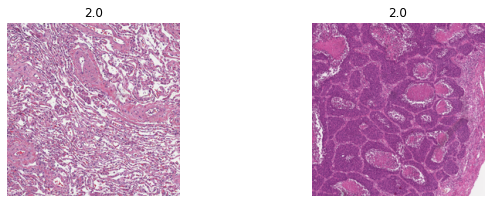

In [55]:
def create_generators() : 

  # create an ImageDataGenerator object with TIFF image format
  datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last', dtype='float32',validation_split=0.2)


  # read TIFF images from a directory
  train_datagenerator = datagen.flow_from_directory(directory="/content/gdrive/MyDrive/project/TCGA",
                                          target_size=(224, 224),
                                          class_mode='sparse',
                                          color_mode='rgb',
                                          classes = ['TCGA-BRCA','TCGA-COAD','TCGA-LUSC','TCGA-SKCM'],
                                          batch_size=32,
                                          save_to_dir=None,
                                          save_prefix='',
                                          save_format='tiff',
                                          follow_links=False,
                                          subset='training',
                                          shuffle=True,
                                          interpolation='nearest')
  # read TIFF images from a directory
  val_datagenerator = datagen.flow_from_directory(directory="/content/gdrive/MyDrive/project/TCGA",
                                          target_size=(224, 224),
                                          class_mode='sparse',
                                          color_mode='rgb',
                                          classes = ['TCGA-BRCA','TCGA-COAD','TCGA-LUSC','TCGA-SKCM'],
                                          batch_size=32,
                                          save_to_dir=None,
                                          save_prefix='',
                                          save_format='tiff',
                                          follow_links=False,
                                          subset='validation',
                                          shuffle=False,
                                          interpolation='nearest')
  print('Training', train_datagenerator)
  print('Validation', val_datagenerator)

  return train_datagenerator, val_datagenerator

def display_images(datagenerator, image_number) :

  # create figure
  fig = plt.figure(figsize=(10, 7))
    
  # setting values to rows and column variables
  rows = 2
  columns = 2

  batch_size = 32
  for i in range(1,image_number):
      img, label = datagenerator.next()
      fig.add_subplot(rows, columns, i)
      print(img.shape)   #  (1,256,256,3)
      plt.title(label[0])
      plt.axis('off')
      plt.imshow(img[0])

train_generator, val_generator = create_generators()

display_images(train_generator, IMAGE_TO_DISPLAY)


In [74]:
def createModel(train_generator, val_generator, train_age_URL, val_age_URL, learning_rate=0.0001, summary_included=False ) : 
  # create base model with pre-trained weights
  base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

  if summary_included == True :
    base_model.summary()

  # freeze all layers in the base model
  for layer in base_model.layers:
      layer.trainable = False

  # add new layers
  x = base_model.output

  print('Base Model Output', x)
  x = GlobalAveragePooling2D()(x)
  print('GlobalAveragePooling2Dt', x)
  x = Dropout(0.2)(x)
  print('Before Dense ', x.shape)
  x = Dense(1024, activation='relu')(x)
  print('Dense 1024', x)
  x = Dropout(0.2)(x)

  print('Last X', x.shape)
  # multi output
  classification = Dense(4, activation='softmax', name='classification')(x)

  print('Classification', classification)
  regression = Dense(1, activation='linear', name='regression')(x)

  # create age layer
  train_age_inputs = create_age_array(train_age_URL)
  val_age_inputs = create_age_array(val_age_URL)

  # create final model
  model = Model(inputs=base_model.input, outputs=[classification, regression])

  # compile model
  model.compile(optimizer=Adam(lr=learning_rate), loss=['sparse_categorical_crossentropy', 'mean_squared_error'], metrics=['accuracy','mae'])

  return model,train_age_inputs,val_age_inputs

def create_age_array(age_URL) :

  # path/to/train_ages.npy
  
  # Load the age data
  age_arrays = np.load('train_age_URL')

  return age_arrays

def create_final_generator(img_gen, age_arr):
    for img, age in zip(img_gen, age_arr):
        yield img, age
      
def train_model(DenseNet201model, train_datagenerator, val_datagenerator, train_age_inputs,val_age_inputs) : 

  print('Model training is started!')
  # train model
  # train model

  model.fit(x=create_final_generator(train_generator, train_age_inputs),
              steps_per_epoch=len(train_datagenerator),
              validation_data=create_final_generator(train_generator, val_age_inputs),
              validation_steps=len(val_datagenerator),
              epochs=10,
              verbose=1,
            callbacks=[
          tf.keras.callbacks.EarlyStopping(
              monitor='val_loss',
              patience=2,
              restore_best_weights=True
          )
      ]
  )
  print('Model is successfully fitted!')




In [72]:
#Create the generators
model,train_age_inputs,val_age_inputs = createModel(train_generator, val_generator)

#Train the mode
train_model(model, train_generator, val_generator,train_age_inputs,val_age_inputs)

Base Model Output KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 1920), dtype=tf.float32, name=None), name='relu/Relu:0', description="created by layer 'relu'")
GlobalAveragePooling2Dt KerasTensor(type_spec=TensorSpec(shape=(None, 1920), dtype=tf.float32, name=None), name='global_average_pooling2d_26/Mean:0', description="created by layer 'global_average_pooling2d_26'")
Before Dense  (None, 1920)
Dense 1024 KerasTensor(type_spec=TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None), name='dense_27/Relu:0', description="created by layer 'dense_27'")
Last X (None, 1024)
Classification KerasTensor(type_spec=TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), name='classification/Softmax:0', description="created by layer 'classification'")
Model training is started!
Epoch 1/10


KeyboardInterrupt: ignored

In [ ]:
from keras.applications import DenseNet201
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

# create data generators
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(directory='path/to/train_images',
                                                     target_size=(224, 224),
                                                     class_mode='categorical',
                                                     batch_size=32)
val_generator = val_datagen.flow_from_directory(directory='path/to/val_images',
                                                   target_size=(224, 224),
                                                   class_mode='categorical',
                                                   batch_size=32)

# load age labels
train_age = np.load('path/to/train_age_labels.npy')
val_age = np.load('path/to/val_age_labels.npy')

# create base model with pre-trained weights
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# add new layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x =


In [61]:
import plotly.graph_objects as go
import pandas as pd


def plot_distribution(pd_series):
    labels = pd_series.value_counts().index.tolist()
    counts = pd_series.value_counts().values.tolist()
    
    pie_plot = go.Pie(labels=labels, values=counts, hole=.3)
    fig = go.Figure(data=[pie_plot])
    fig.update_layout(title_text='Distribution for %s' % pd_series.name)
    
    fig.show()

bins = [0, 10, 20, 30, 40, 60, 80, np.inf]
names = ['<10', '10-20', '20-30', '30-40', '40-60', '60-80', '80+']
#age_binned = pd.cut(df['age'], bins, labels=names)
#plot_distribution(age_binned)

In [62]:
def visualize_augmentations(data_generator: ImageDataGenerator, df: pd.DataFrame):
    """Visualizes the keras augmentations with matplotlib in 3x3 grid. This function is part of create_generators() and
    can be accessed from there.

    Parameters
    ----------
    data_generator : Iterator
        The keras data generator of your training data.
    df : pd.DataFrame
        The Pandas DataFrame containing your training data.
    """
    # super hacky way of creating a small dataframe with one image
    series = df.iloc[2]

    df_augmentation_visualization = pd.concat([series, series], axis=1).transpose()

    iterator_visualizations = data_generator.flow_from_dataframe(  # type: ignore
        dataframe=df_augmentation_visualization,
        x_col="image_location",
        y_col="price",
        class_mode="raw",
        target_size=(224, 224),  # size of the image
        batch_size=1,  # use only one image for visualization
    )

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)  # create a 3x3 grid
        batch = next(iterator_visualizations)  # get the next image of the generator (always the same image)
        img = batch[0]  # type: ignore
        img = img[0, :, :, :]  # remove one dimension for plotting without issues
        plt.imshow(img)
    plt.show()
    plt.close()

In [63]:
def small_cnn() -> Sequential:
    """A very small custom convolutional neural network with image input dimensions of 224x224x3.

    Returns
    -------
    Sequential
        The keras Sequential model.
    """
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(224, 224, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation="relu"))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(1))

    return model

NameError: ignored

In [ ]:
def run():
    ...
    small_cnn_history = run_model(
        model_name="small_cnn",
        model_function=small_cnn(),
        lr=0.001,
        train_generator=train_generator,
        validation_generator=validation_generator,
        test_generator=test_generator,
    )

In [ ]:
def open_images(inference_folder: str) -> np.ndarray:
    """Loads images from a folder and prepare them for inferencing.

    Parameters
    ----------
    inference_folder : str
        Location of images for inferencing.

    Returns
    -------
    np.ndarray
        List of images as numpy arrays transformed to fit the efficient_net model input specs.
    """
    images = []
    for img in os.listdir(inference_folder):
        img_location = os.path.join(inference_folder, img)  # create full path to image

        with Image.open(img_location) as img:  # open image with pillow

            img = np.array(img)
            img = img[:, :, :3]
            img = np.expand_dims(img, axis=0)  # add 0 dimension to fit input shape of efficient_net

        images.append(img)
    images_array = np.vstack(images)  # combine images efficiently to a numpy array
    return images_array